# Grouping, resampling and aggregations

The hourly data over 23 years contain about ~800,000 observations. It is not viable to extract any knowledge by just looking at them ony by one. Thus an analysis of this sort of data almost always consists of proper **grouping** (selecting which rows we want to condense) and **aggregation** (applying an operation to produce a single or a handful of values from them).

In [1]:
# Necessary import evil
from datetime import datetime
from typing import Annotated

import pandas as pd
from pandas import IndexSlice as idx, Grouper
import pandera as pa
from pandera import DataFrameModel
from pandera.typing import Int16, DataFrame, Series, Category, Index

from weatherlyser.loader import load_chmi_data
from weatherlyser.pa_models import HistoricalWeatherDataFrame

In [2]:
# Load the saved data
data = pd.read_parquet("../data/open_meteo_2000-2022.pq")

data.head()

quantity                              apparent_temperature  cloudcover  \
time                      model                                          
2000-01-01 00:00:00+00:00 best_match                  -4.8        85.0   
                          cerra                       -5.8       100.0   
                          era5                        -3.1        85.0   
                          era5_land                    NaN         NaN   
2000-01-01 01:00:00+00:00 best_match                  -5.0        86.0   

quantity                              cloudcover_high  cloudcover_low  \
time                      model                                         
2000-01-01 00:00:00+00:00 best_match              0.0            94.0   
                          cerra                  40.0            73.0   
                          era5                    0.0            94.0   
                          era5_land               NaN             NaN   
2000-01-01 01:00:00+00:00 best_match              0.0            96.0   

quantity                              cloudcover_mid  dewpoint_2m  \
time                      model                                     
2000-01-01 00:00:00+00:00 best_match             0.0         -2.7   
                          cerra                 46.0         -3.1   
                          era5                   0.0         -1.4   
                          era5_land              NaN         -2.7   
2000-01-01 01:00:00+00:00 best_match             0.0         -2.9   

quantity                              diffuse_radiation  \
time                      model                           
2000-01-01 00:00:00+00:00 best_match                0.0   
                          cerra                     0.0   
                          era5                      0.0   
                          era5_land                 NaN   
2000-01-01 01:00:00+00:00 best_match                0.0   

quantity                              direct_normal_irradiance  \
time                      model                                  
2000-01-01 00:00:00+00:00 best_match                       0.0   
                          cerra                            0.0   
                          era5                             0.0   
                          era5_land                        NaN   
2000-01-01 01:00:00+00:00 best_match                       0.0   

quantity                              direct_radiation  \
time                      model                          
2000-01-01 00:00:00+00:00 best_match               0.0   
                          cerra                    0.0   
                          era5                     0.0   
                          era5_land                NaN   
2000-01-01 01:00:00+00:00 best_match               0.0   

quantity                              et0_fao_evapotranspiration  ...  \
time                      model                                   ...   
2000-01-01 00:00:00+00:00 best_match                         0.0  ...   
                          cerra                              0.0  ...   
                          era5                               0.0  ...   
                          era5_land                          NaN  ...   
2000-01-01 01:00:00+00:00 best_match                         0.0  ...   

quantity                              soil_temperature_7_to_28cm  \
time                      model                                    
2000-01-01 00:00:00+00:00 best_match                         0.0   
                          cerra                              NaN   
                          era5                               0.4   
                          era5_land                          0.0   
2000-01-01 01:00:00+00:00 best_match                         0.0   

quantity                              surface_pressure  temperature_2m  \
time                      model                                          
2000-01-01 00:00:00+00:00 best_match             980.4          

In [3]:
# We will skip this now as it takes a lot of time!
# HistoricalWeatherDataFrame.validate(data)

In [4]:
# Most meteorological reporting is done in local time
data = data.tz_convert(level="time", tz="Europe/Prague")

For simplicity, we will be working with the "best model" for now. 

In [5]:
best_model_data = data.loc[idx[:, "best_match"], :].reset_index("model", drop=True)
best_model_data.head()

quantity,apparent_temperature,cloudcover,cloudcover_high,cloudcover_low,cloudcover_mid,dewpoint_2m,diffuse_radiation,direct_normal_irradiance,direct_radiation,et0_fao_evapotranspiration,...,soil_temperature_7_to_28cm,surface_pressure,temperature_2m,vapor_pressure_deficit,weathercode,winddirection_100m,winddirection_10m,windgusts_10m,windspeed_100m,windspeed_10m
time,,,,,,,,,,,,,,,,,,,,,
2000-01-01 01:00:00+01:00,-4.8,85.0,0.0,94.0,0.0,-2.7,0.0,0.0,0.0,0.0,...,0.0,980.4,-1.4,0.05,3,255.0,243.0,10.1,12.3,5.6
2000-01-01 02:00:00+01:00,-5.0,86.0,0.0,96.0,0.0,-2.9,0.0,0.0,0.0,0.0,...,0.0,980.5,-1.6,0.05,3,249.0,235.0,11.2,12.3,5.7
2000-01-01 03:00:00+01:00,-5.3,91.0,0.0,93.0,12.0,-3.0,0.0,0.0,0.0,0.0,...,0.0,980.7,-1.8,0.05,3,246.0,232.0,11.9,13.0,6.4
2000-01-01 04:00:00+01:00,-5.6,89.0,1.0,91.0,11.0,-3.2,0.0,0.0,0.0,0.0,...,0.0,980.6,-2.0,0.05,3,244.0,233.0,12.6,14.0,7.2
2000-01-01 05:00:00+01:00,-6.2,100.0,77.0,79.0,54.0,-3.7,0.0,0.0,0.0,0.0,...,0.0,980.5,-2.4,0.05,3,242.0,231.0,13.0,14.3,7.4


The weather description will become handy for our first aggregations.

In [6]:
from weatherlyser.pa_models import WEATHER_CODES


class WeatherCodeModel(pa.DataFrameModel):
    weathercode: Int16 = pa.Field(ge=0, le=99, nullable=True)

@pa.check_types
# *** Annotations as a task
def get_weather_description(df: DataFrame[WeatherCodeModel]) -> Series[Category]:
    """Converts the weather code column in a Pandas DataFrame
    to a categorical column with the weather descriptions as the category levels.

    Args:
        df: A Pandas DataFrame with a column called "weathercode".

    Returns:
        A categorical series with a string representation of the code.
    """
    # *** The mapping as a task
    return df["weathercode"].map(WEATHER_CODES).astype("category")

get_weather_description(best_model_data)

time
2000-01-01 01:00:00+01:00        Overcast
2000-01-01 02:00:00+01:00        Overcast
2000-01-01 03:00:00+01:00        Overcast
2000-01-01 04:00:00+01:00        Overcast
2000-01-01 05:00:00+01:00        Overcast
                                 ...     
2022-12-30 21:00:00+01:00        Overcast
2022-12-30 22:00:00+01:00        Overcast
2022-12-30 23:00:00+01:00        Overcast
2022-12-31 00:00:00+01:00        Overcast
2022-12-31 01:00:00+01:00    Mainly clear
Name: weathercode, Length: 201601, dtype: category
Categories (13, object): ['Clear sky', 'Drizzle, dense intensity', 'Drizzle, light intensity', 'Drizzle, moderate intensity', ..., 'Rain, slight intensity', 'Snow fall, heavy intensity', 'Snow fall, moderate intensity', 'Snow fall, slight intensity']

In [7]:
best_model_data = best_model_data.assign(
    description=get_weather_description(best_model_data)
)

## Grouping and simple aggregations

In [8]:
grouped = best_model_data.groupby("description")
grouped

What is this object? Is this some numerical result yet? No, it is actually just the segmentation of the dataframe into **groups** of **rows** that will be handled by subsequent operation.

The groupby mechanism ensures that the operations done on the sub-dataframes are recombined together with the grouping key(s) as index (levels of index):

In [9]:
# Select a column and do a mean over it, within the categories
grouped["rain"].mean()

description
Clear sky                        0.000000
Drizzle, dense intensity         1.081151
Drizzle, light intensity         0.211168
Drizzle, moderate intensity      0.655276
Mainly clear                     0.000000
Overcast                         0.000000
Partly cloudy                    0.000000
Rain, heavy intensity            9.495000
Rain, moderate intensity         3.432914
Rain, slight intensity           1.698314
Snow fall, heavy intensity       0.109375
Snow fall, moderate intensity    0.070024
Snow fall, slight intensity      0.050667
Name: rain, dtype: float64

In [10]:
# Multiple aggregations over the same column
grouped["rain"].agg(["min", "mean", "max"])

,min,mean,max
description,,,
Clear sky,0.0,0.000000,0.0
"Drizzle, dense intensity",1.0,1.081151,1.2
"Drizzle, light intensity",0.1,0.211168,0.4
"Drizzle, moderate intensity",0.5,0.655276,0.9
Mainly clear,0.0,0.000000,0.0
Overcast,0.0,0.000000,0.0
Partly cloudy,0.0,0.000000,0.0
"Rain, heavy intensity",7.7,9.495000,15.7
"Rain, moderate intensity",2.5,3.432914,7.4


## Resampling

With time series, we usually do not want to group over (all) values of column, but over some interval (typically of the index or index level). The mechanism is pretty much the same but the method is called `resample` and we need an extra argument, frequency.

So in order to get each year's total precipitation:

In [11]:
best_model_data.resample("1Y")  # 1Y = every one year

This, in parallel to the groupby result is an object just holding the segmentations and any aggregation must be done on it:

In [12]:
best_model_data.resample("1Y")["precipitation"].sum()

time
2000-12-31 00:00:00+01:00    586.1
2001-12-31 00:00:00+01:00    750.0
2002-12-31 00:00:00+01:00    953.1
2003-12-31 00:00:00+01:00    425.6
2004-12-31 00:00:00+01:00    587.6
2005-12-31 00:00:00+01:00    618.0
2006-12-31 00:00:00+01:00    581.2
2007-12-31 00:00:00+01:00    647.9
2008-12-31 00:00:00+01:00    611.7
2009-12-31 00:00:00+01:00    691.1
2010-12-31 00:00:00+01:00    820.9
2011-12-31 00:00:00+01:00    589.1
2012-12-31 00:00:00+01:00    674.8
2013-12-31 00:00:00+01:00    701.6
2014-12-31 00:00:00+01:00    614.2
2015-12-31 00:00:00+01:00    518.9
2016-12-31 00:00:00+01:00    635.7
2017-12-31 00:00:00+01:00    659.8
2018-12-31 00:00:00+01:00    424.3
2019-12-31 00:00:00+01:00    575.4
2020-12-31 00:00:00+01:00    694.3
2021-12-31 00:00:00+01:00    791.4
2022-12-31 00:00:00+01:00    848.6
Freq: A-DEC, Name: precipitation, dtype: float64

We will not be plotting much in this workshop but the simple `plot` method will still come handy to see what we calculated.

<Axes: xlabel='time'>

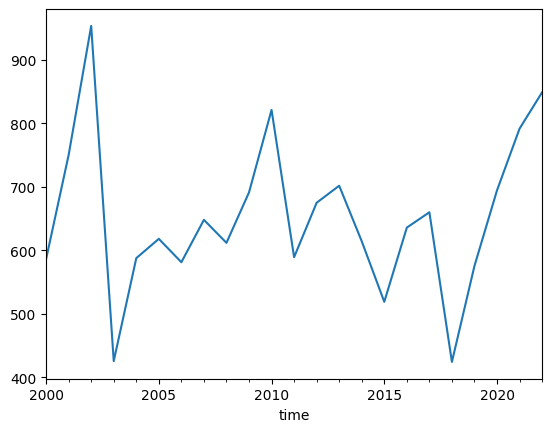

In [13]:
best_model_data.resample("1Y")["precipitation"].sum().plot()

**Exercise:** Write a function `get_daily_temperature_stats` that finds the minimum, mean and maximum temperatures for each day. (Bonus: You can annotate it with a pandera model).

In [14]:
def get_daily_temperature_stats(df: pd.DataFrame) -> pd.Series:
    return df["temperature_2m"].resample("1D").agg(["min", "mean", "max"])

get_daily_temperature_stats(best_model_data)

,min,mean,max
time,,,
2000-01-01 00:00:00+01:00,-3.5,-1.047826,0.3
2000-01-02 00:00:00+01:00,-1.3,0.512500,2.0
2000-01-03 00:00:00+01:00,-2.2,-0.337500,2.0
2000-01-04 00:00:00+01:00,-1.1,1.550000,3.9
2000-01-05 00:00:00+01:00,-3.3,2.587500,5.1
...,...,...,...
2022-12-27 00:00:00+01:00,0.3,3.216667,7.4
2022-12-28 00:00:00+01:00,-0.4,2.850000,6.3
2022-12-29 00:00:00+01:00,5.1,7.541667,10.7


Sometimes, we want to combine grouping and resampling in one operation (although a nested grouping will probably work too). The **`Grouper`** class, used instead of strings as the `groupby` argument, allows to combine columns and normal/time index levels: 

In [15]:
data.groupby([Grouper(level="time", freq="1D"), Grouper(level="model")])["precipitation"].sum() #.plot()

time                       model     
2000-01-01 00:00:00+01:00  best_match    2.5
                           cerra         3.3
                           era5          2.5
                           era5_land     0.0
2000-01-02 00:00:00+01:00  best_match    0.9
                                        ... 
2022-12-30 00:00:00+01:00  era5          1.4
                           era5_land     0.0
2022-12-31 00:00:00+01:00  best_match    0.0
                           era5          0.0
                           era5_land     0.0
Name: precipitation, Length: 33056, dtype: float64

In [16]:
# Have names for the aggregations: name=>(field, agg.method)
data.groupby([Grouper(level="time", freq="1D"), Grouper(level="model")]).agg(
    min_pressure=("surface_pressure", "min")
)

min_pressure
time                      model                   
2000-01-01 00:00:00+01:00 best_match         977.9
                          cerra              977.8
                          era5               977.9
                          era5_land            NaN
2000-01-02 00:00:00+01:00 best_match         978.7
...                                            ...
2022-12-30 00:00:00+01:00 era5               969.7
                          era5_land            NaN
2022-12-31 00:00:00+01:00 best_match         971.1
                          era5               971.1
                          era5_land            NaN

[33056 rows x 1 columns]

**Exercise:** Can you modify your get_daily_temperature_stats so that it works for the entire data, including model?

In [17]:
import numpy as np


@pa.extensions.register_check_method()
def has_daily_index(df):
    # Check that the set of dates is the same as the set of all datetimes (a bit ugly)
    return len(np.unique(df.index.get_level_values("time").date)) == df.index.get_level_values("time").nunique()


class TemperatureModel(DataFrameModel):
    temperature_2m: float = pa.Field(nullable=True)

    time: Index[Annotated[pd.DatetimeTZDtype, "ns", "Europe/Prague"]]
    model: Index[str]


class TemperatureStatsModel(DataFrameModel):
    min_temp: float = pa.Field(nullable=True)
    max_temp: float = pa.Field(nullable=True)

    time: Index[Annotated[pd.DatetimeTZDtype, "ns", "Europe/Prague"]]
    model: Index[str]

    class Config:
        has_daily_index = ()


@pa.check_types
def get_daily_temperature_stats2(df: DataFrame[TemperatureModel]) -> DataFrame[TemperatureStatsModel]:
    return df.groupby([Grouper(level="time", freq="1D"), Grouper(level="model")]).agg(
        min_temp = ("temperature_2m", "min"),
        max_temp = ("temperature_2m", "max")
    )

temperature_stats2 = get_daily_temperature_stats2(data)

### Feature engineering



When looking at periodically repeating phenomena, we quite often do not want to "just" resample but look at aggregations over all the repeating intervals, such as when we are interested in (historical) mean temperature in May. The `resample` or `groupby` (even with Grouper) will not work straightaway.

The easiest way is to construct helper columns with the time series feature (such as month number).

In [18]:
data.index.get_level_values(0)

DatetimeIndex(['2000-01-01 01:00:00+01:00', '2000-01-01 01:00:00+01:00',
               '2000-01-01 01:00:00+01:00', '2000-01-01 01:00:00+01:00',
               '2000-01-01 02:00:00+01:00', '2000-01-01 02:00:00+01:00',
               '2000-01-01 02:00:00+01:00', '2000-01-01 02:00:00+01:00',
               '2000-01-01 03:00:00+01:00', '2000-01-01 03:00:00+01:00',
               ...
               '2022-12-30 22:00:00+01:00', '2022-12-30 23:00:00+01:00',
               '2022-12-30 23:00:00+01:00', '2022-12-30 23:00:00+01:00',
               '2022-12-31 00:00:00+01:00', '2022-12-31 00:00:00+01:00',
               '2022-12-31 00:00:00+01:00', '2022-12-31 01:00:00+01:00',
               '2022-12-31 01:00:00+01:00', '2022-12-31 01:00:00+01:00'],
              dtype='datetime64[ns, Europe/Prague]', name='time', length=792911, freq=None)

In [19]:
mean_temperature_per_month = best_model_data.assign(
    month=lambda df: df.index.get_level_values(0).month
).groupby("month")["temperature_2m"].mean()

mean_temperature_per_month

month
1     -0.571545
2      0.580000
3      3.869407
4      8.896371
5     13.576706
6     17.526504
7     19.227788
8     19.107375
9     14.413309
10     9.578442
11     4.616806
12     0.848525
Name: temperature_2m, dtype: float64

<Axes: xlabel='month'>

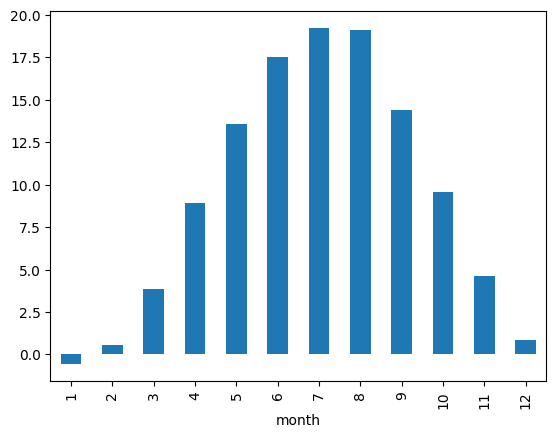

In [20]:
mean_temperature_per_month.plot(kind="bar")

**Exercise** For each calendar month (i.e. January, ...), find the typical (mean) hourly evolution of temperature over the course of the day. For that, you can use the attributes of the index and the method `unstack` to turn a level of a hierarchical index into columns (for each month).

In [21]:
class DailyMonthlyPatternModel(DataFrameModel):
    # We must use alias as integer cannot be an attribute name
    jan: float = pa.Field(alias=1)
    feb: float = pa.Field(alias=2)
    mar: float = pa.Field(alias=3)
    apr: float = pa.Field(alias=4)
    may: float = pa.Field(alias=5)
    jun: float = pa.Field(alias=6)
    jul: float = pa.Field(alias=7)
    aug: float = pa.Field(alias=8)
    sep: float = pa.Field(alias=9)
    oct: float = pa.Field(alias=10)
    nov: float = pa.Field(alias=11)
    dec: float = pa.Field(alias=12)

    hour: Index[pd.Int32Dtype] = pa.Field(ge=0, le=23)


@pa.check_types
def daily_monthly_pattern(df: pd.DataFrame) -> DataFrame[DailyMonthlyPatternModel]:
    long_form = df.assign(
        hour=df.index.hour,
        month=df.index.month
    ).groupby(["hour", "month"])["temperature_2m"].mean()
    return long_form.unstack("month")

daily_monthly_pattern(best_model_data)

month,1,2,3,4,5,6,7,8,9,10,11,12
hour,,,,,,,,,,,,
0,-1.364326,-0.848154,1.684151,6.635362,11.365498,15.307391,17.043619,17.153997,12.791449,8.224965,3.584928,0.122160
1,-1.459187,-1.024615,1.362553,6.041594,10.742076,14.657971,16.443198,16.595372,12.325942,7.925666,3.436667,0.053717
2,-1.540252,-1.158769,1.065217,5.503043,10.198036,14.096232,15.918093,16.085133,11.921014,7.618342,3.321739,-0.026404
3,-1.615989,-1.280154,0.902945,5.037391,9.722020,13.601884,15.431697,15.639832,11.568696,7.432258,3.230870,-0.069663
4,-1.682889,-1.399385,0.710659,4.637681,9.294250,13.161159,15.013885,15.223001,11.240000,7.219635,3.134638,-0.114747
5,-1.736746,-1.497692,0.543759,4.290580,8.909257,12.789855,14.666900,14.844180,10.950435,7.042777,3.066377,-0.149157
6,-1.786816,-1.571385,0.379383,4.000145,8.738289,12.862899,14.552174,14.537728,10.695652,6.894951,3.006957,-0.176966
7,-1.830014,-1.652462,0.463254,4.169855,9.801543,14.181884,15.626227,14.882048,10.530870,6.761290,2.969130,-0.213904
8,-1.726648,-1.274769,1.766480,5.850435,11.644741,15.796087,17.345021,16.595231,11.341159,6.922160,3.282029,-0.059410


month,1,2,3,4,5,6,7,8,9,10,11,12
hour,,,,,,,,,,,,
0,-1.364326,-0.848154,1.684151,6.635362,11.365498,15.307391,17.043619,17.153997,12.791449,8.224965,3.584928,0.122160
1,-1.459187,-1.024615,1.362553,6.041594,10.742076,14.657971,16.443198,16.595372,12.325942,7.925666,3.436667,0.053717
2,-1.540252,-1.158769,1.065217,5.503043,10.198036,14.096232,15.918093,16.085133,11.921014,7.618342,3.321739,-0.026404
3,-1.615989,-1.280154,0.902945,5.037391,9.722020,13.601884,15.431697,15.639832,11.568696,7.432258,3.230870,-0.069663
4,-1.682889,-1.399385,0.710659,4.637681,9.294250,13.161159,15.013885,15.223001,11.240000,7.219635,3.134638,-0.114747
5,-1.736746,-1.497692,0.543759,4.290580,8.909257,12.789855,14.666900,14.844180,10.950435,7.042777,3.066377,-0.149157
6,-1.786816,-1.571385,0.379383,4.000145,8.738289,12.862899,14.552174,14.537728,10.695652,6.894951,3.006957,-0.176966
7,-1.830014,-1.652462,0.463254,4.169855,9.801543,14.181884,15.626227,14.882048,10.530870,6.761290,2.969130,-0.213904
8,-1.726648,-1.274769,1.766480,5.850435,11.644741,15.796087,17.345021,16.595231,11.341159,6.922160,3.282029,-0.059410


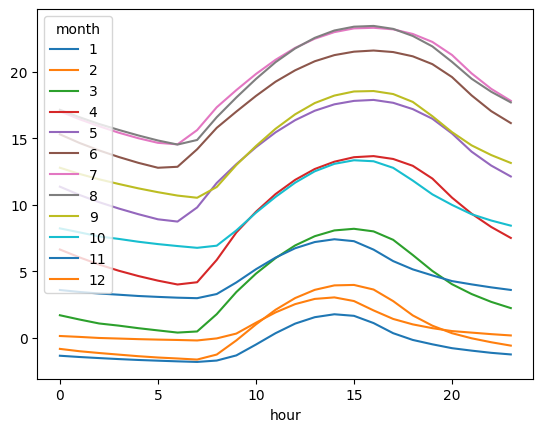

In [22]:
daily_monthly_pattern(best_model_data).plot()
daily_monthly_pattern(best_model_data)

**Complex exercise**: For each year, find how many minimum and maximum temperature days it has (the media tell us the weather is becoming more and more extreme!)

We will do this in multiple steps:

* Construct features "month" and "day".
* Group over those and find the extremes, use `idxmax`, `idxmin` methods.
* Extract the year from both series (beware, that you need to use the `.dt` accessor for series datetime methods)
* Use value_counts or groupby to count the year occurences

Optional parts:
* Create a DataFrameModel checking the output: int as index (should be consecutive years somewhere around 2000), two columns (min_count, max_count?) as positive integes
* Create a hypothesis test showing that the total number of extremes does not exceed 366 over a dataframe with more than one-year worth of data

In [23]:
class MinMaxModel(DataFrameModel):
    # Hack
    time: Index[datetime] = pa.Field(coerce=True)

    min: float
    max: float


class YearExtremesModel(DataFrameModel):
    min_count: int = pa.Field(ge=0, le=366)
    max_count: int = pa.Field(ge=0, le=366)

    year: Index[pd.Int32Dtype] = pa.Field()



@pa.check_types
def find_year_extremes(temperature_data: DataFrame[MinMaxModel]) -> DataFrame[YearExtremesModel]:
    temperature_With_features = temperature_data.assign(
        month=temperature_data.index.month,
        day=temperature_data.index.day,
        year=temperature_data.index.year
    )

    extreme_dates = temperature_With_features.groupby(["month", "day"]).agg(
        {
            "max": ["idxmax", "max"],
            "min": ["idxmin", "min"]
        }
    )

    extreme_years = extreme_dates.assign(
        min_year=lambda df: df[("min", "idxmin")].dt.year,
        max_year=lambda df: df[("max", "idxmax")].dt.year
    )[["min_year", "max_year"]]

    extreme_counts = pd.merge(
        extreme_years.groupby("min_year").size().rename("min_count"),
        extreme_years.groupby("max_year").size().rename("max_count"),
        left_index=True,
        right_index=True,
    )

    return extreme_counts


find_year_extremes(temperature_data=get_daily_temperature_stats(best_model_data))

,min_count,max_count
min_year,,
2000,10,16
2001,25,7
2002,17,17
2003,16,19
2004,18,12
2005,38,9
2006,20,18
2007,14,24
2008,12,8


In [43]:
from hypothesis import given
from hypothesis import strategies as st

from datetime import date

@st.composite
def min_max_input(draw) -> pd.DataFrame:
    min_date = draw(st.dates(min_value=date(2020,1,1), max_value=date(2030, 12, 31)))
    length = draw(st.integers(min_value=300, max_value=1000))
    index = pd.date_range(min_date, min_date + pd.Timedelta(days = length-1))
    minima = draw(st.lists(elements=st.floats(min_value=-50, max_value=50), min_size=length, max_size=length))
    differences = draw(st.lists(elements=st.floats(min_value=0, max_value=50), min_size=length, max_size=length))
    df = pd.DataFrame({
            "min": minima
        },
        index=index,
    ).assign(max=lambda df: df["min"] + differences)
    return df            

@given(df=min_max_input())
def test_reasonable_range(df):
    extremes = find_year_extremes(df)

    print(df.shape)

    if df.shape[0] > 365:
        assert 365 <= extremes["min_count"].sum() <= 366
    else:
        assert extremes["min_count"].sum() == df.shape[0]


test_reasonable_range()

(300, 2)
You can add @seed(316124435792572543630431648532358259051) to this test to reproduce this failure.


FailedHealthCheck: The smallest natural example for your test is extremely large. This makes it difficult for Hypothesis to generate good examples, especially when trying to reduce failing ones at the end. Consider reducing the size of your data if it is of a fixed size. You could also fix this by improving how your data shrinks (see https://hypothesis.readthedocs.io/en/latest/data.html#shrinking for details), or by introducing default values inside your strategy. e.g. could you replace some arguments with their defaults by using one_of(none(), some_complex_strategy)?
See https://hypothesis.readthedocs.io/en/latest/healthchecks.html for more information about this. If you want to disable just this health check, add HealthCheck.large_base_example to the suppress_health_check settings for this test.

In [24]:
# On CHMI data

chmi_data = load_chmi_data()
chmi_data_renamed = chmi_data.rename(columns={"minimum_temperature": "min", "maximum_temperature": "max"})
find_year_extremes(chmi_data_renamed)

,min_count,max_count
1961,5,16
1962,9,4
1963,14,4
1964,7,4
1965,7,2
1966,2,5
1968,6,8
1969,6,3
1970,8,1
1971,12,5
